In [1]:
import json
import matplotlib.pyplot as plt
import numpy as np
from PIL import Image
import xview_coco
import os
import random
from shutil import copyfile

%matplotlib inline

In [30]:
# Opening JSON file
f = open('train_labels/xView_train.geojson', 'r')

# returns JSON object as
# a dictionary
data = json.load(f)

# Closing file
f.close()

In [41]:
index = 123456

In [42]:
data['features'][index]

{'type': 'Feature',
 'properties': {'bounds_imcoords': '161,3075,178,3088',
  'edited_by': 'wwdanielramirez',
  'cat_id': '1040010026637400',
  'type_id': 18,
  'ingest_time': '2017/08/03 19:16:08.696+00',
  'index_right': 1452,
  'image_id': '1452.tif',
  'point_geom': '0101000020E61000002F4F9A3F3E870840C17B410DCF604240',
  'feature_id': 561065,
  'grid_file': 'Grid16.shp'},
 'geometry': {'type': 'Polygon',
  'coordinates': [[[3.066011708184667, 36.75629998887999],
    [3.066011708184667, 36.75633744889147],
    [3.066061688300942, 36.75633744889147],
    [3.066061688300942, 36.75629998887999],
    [3.066011708184667, 36.75629998887999]]]}}

In [43]:
bbox = data['features'][index]['properties']['bounds_imcoords']
print(bbox)
print(type(bbox))
bbox = [int(x) for x in bbox.split(',')]
print(bbox)
print(type(bbox[0]))

161,3075,178,3088
<class 'str'>
[161, 3075, 178, 3088]
<class 'int'>


In [44]:
imgstr = data['features'][index]['properties']['image_id']
print(imgstr)

1452.tif


(3148, 3913, 3)
[3075, 3088, 161, 178]
(13, 17, 3)


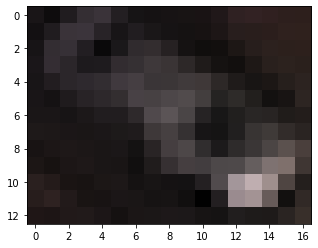

In [45]:
img = Image.open("train_images/"+imgstr)

arr = np.asarray(img)
print(arr.shape)
#print(type(arr))

print([bbox[1], bbox[3], bbox[0], bbox[2]])

img2 = arr[bbox[1]:bbox[3], bbox[0]:bbox[2], :]
print(img2.shape)

plt.imshow(img2)

#Image.transform(size, method, data=None, resample=0, fill=1, fillcolor=None)

In [8]:
#from pprint import pprint
from pyproj import Proj, transform
import rasterio as rio

def image_latlon_pxpy(latitude, longitude):
    dataset = rio.open("train_images/"+imgstr, crs='epsg:3857')
    coords = transform(Proj(init='epsg:4326'), Proj(init='epsg:3857'), longitude, latitude)
    px, py = coords[0], coords[1]
    print(px,py)
    px_pc = (px - dataset.bounds.left) / (dataset.bounds.right - dataset.bounds.left)
    py_pc = (dataset.bounds.top - py) / (dataset.bounds.top - dataset.bounds.bottom)
    return (px_pc*dataset.width, py_pc*dataset.height)

#pprint(image_latlon_pxpy(39.603786, -104.9429))
#(256,256)

for coord in data['features'][50]['geometry']['coordinates'][0]:
    print('coord', coord)
    row,col = image_latlon_pxpy(latitude=coord[1], longitude=coord[0])
    print(row,col)

coord [-90.53447284267835, 14.570009860618576]
-10078251.41608441 1639694.6105493787
-2933060749661.615 -477198293251.45483
coord [-90.53447284267835, 14.570149137293045]
-10078251.41608441 1639710.6299303884
-2933060749661.615 -477202955393.5119
coord [-90.5342437701325, 14.570149137293045]
-10078225.91584525 1639710.6299303884
-2933053328292.6265 -477202955393.5119
coord [-90.5342437701325, 14.570009860618576]
-10078225.91584525 1639694.6105493787
-2933053328292.6265 -477198293251.45483
coord [-90.53447284267835, 14.570009860618576]
-10078251.41608441 1639694.6105493787
-2933060749661.615 -477198293251.45483


C:\Users\Admin\anaconda3\envs\pytorch38\lib\site-packages\pyproj\crs\crs.py:131: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\Admin\anaconda3\envs\pytorch38\lib\site-packages\pyproj\crs\crs.py:131: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\Admin\AppData\Local\Temp/ipykernel_8440/2294188698.py:7: DeprecationWarning: This function is deprecated. See: https://pyproj4.github.io/pyproj/stable/gotchas.html#upgrading-to-pypr

In [78]:
train_or_val = "train"

In [2]:
geojson_path = train_or_val+"_labels/xView_"+train_or_val+".geojson"
classes_path = "xview-class-labels.txt"
image_folder = train_or_val+"_images/"
json_path = xview_coco.make_json(geojson_path, classes_path, image_folder)

Found 846 images in folder
50 images processed
100 images processed
150 images processed
200 images processed
250 images processed
300 images processed
350 images processed
400 images processed
450 images processed
500 images processed
550 images processed
600 images processed
650 images processed
700 images processed
750 images processed
800 images processed
All images processed
JSON sections complete
Part 1 complete
Corrected 5073 boxes with coords below 0 and 4941 with coords larger than image
Removed 32 annotations
New json train_labels/xView_train.json


'train_labels/xView_train.json'

In [7]:
with open(json_path, 'r') as f:
    gt = json.load(f)

In [77]:
if not os.path.exists('chips_'+train_or_val):
    os.makedirs('chips_'+train_or_val)

j = 0

#Process each annotation one by one
for a in gt['annotations']:
    
    # there's an error so start from here
    if j >= 421955:
        
        # Key annotation information
        bbox = a['bbox']
        im_id = a['image_id']
        
        # some images don't exist.......
        if im_id not in [1395]:
            
            imgstr = "train_images/"+str(im_id)+".tif"
            img = Image.open(imgstr)
            arr = np.asarray(img)
            # bbox is x, y, width, height
            arr2 = arr[bbox[1]:bbox[1]+bbox[3], bbox[0]:bbox[0]+bbox[2], :]
            #print('bbox', bbox)
            #print(arr.shape)
            #print(arr2.shape)
            #plt.imshow(arr2)

            # create a directory with the class name
            if not os.path.exists('chips_'+train_or_val+'/'+str(a['category_id'])):
                os.makedirs('chips_'+train_or_val+'/'+str(a['category_id']))

            img2 = Image.fromarray(arr2.astype('uint8'), 'RGB')
            img2 = img2.save('chips_'+train_or_val+'/'+str(a['category_id'])+"/"+str(j)+".png")

    if j%10000 == 0:
        print(j, "/", len(gt['annotations']))
    j += 1--

0 / 601905
10000 / 601905
20000 / 601905
30000 / 601905
40000 / 601905
50000 / 601905
60000 / 601905
70000 / 601905
80000 / 601905
90000 / 601905
100000 / 601905
110000 / 601905
120000 / 601905
130000 / 601905
140000 / 601905
150000 / 601905
160000 / 601905
170000 / 601905
180000 / 601905
190000 / 601905
200000 / 601905
210000 / 601905
220000 / 601905
230000 / 601905
240000 / 601905
250000 / 601905
260000 / 601905
270000 / 601905
280000 / 601905
290000 / 601905
300000 / 601905
310000 / 601905
320000 / 601905
330000 / 601905
340000 / 601905
350000 / 601905
360000 / 601905
370000 / 601905
380000 / 601905
390000 / 601905
400000 / 601905
410000 / 601905
420000 / 601905
430000 / 601905
440000 / 601905
450000 / 601905
460000 / 601905
470000 / 601905
480000 / 601905
490000 / 601905
500000 / 601905
510000 / 601905
520000 / 601905
530000 / 601905
540000 / 601905
550000 / 601905
560000 / 601905
570000 / 601905
580000 / 601905
590000 / 601905
600000 / 601905


In [75]:
j

421955

In [83]:
# with open("xview-class-labels.txt", "r") as f:
#     xv = f.read().splitlines()

In [84]:
# for x in xv:
#     num, name = x.split(":")
#     name = name.replace("/", " ")
#     os.rename("chips_train_all_examples/"+num, "chips_train_all_examples/"+name)

In [28]:
# go through each subdirectory and copy 80% images into new train directory and 20% into new test directory
for root, dirs, files in os.walk("chips_train_all_examples"):
    break

for d in dirs:
    print(d)
    for root, dirs2, files in os.walk("chips_train_all_examples/"+d):
        break
    train_files = []
    test_files = []
    for fi in files:
        if random.random() <= 0.8:
            train_files.append(fi)
        else:
            test_files.append(fi)
    if not os.path.exists("chips_train"):
        os.makedirs("chips_train")
    for fi in train_files:
        if not os.path.exists("chips_train/"+d):
            os.makedirs("chips_train/"+d)
        src = "chips_train_all_examples/"+d+"/"+fi
        dst = "chips_train/"+d+"/"+fi
        copyfile(src, dst)
    if not os.path.exists("chips_test"):
        os.makedirs("chips_test")
    for fi in test_files:
        if not os.path.exists("chips_test/"+d):
            os.makedirs("chips_test/"+d)
        src = "chips_train_all_examples/"+d+"/"+fi
        dst = "chips_test/"+d+"/"+fi
        copyfile(src, dst)

In [10]:
for root, dirs, filenames in os.walk("chips_train", topdown=False):
    pass

class_info = {}
for d in dirs:
    all_sizes = []
    for root, dirs, filenames in os.walk("chips_train/"+d, topdown=False):
        pass
    print(d, len(filenames))
    for f in filenames:
        imgstr = "chips_train/"+d+"/"+f
        img = Image.open(imgstr)
        arr = np.asarray(img)
        all_sizes.append(arr.shape[:2])
    class_info[d] = {
        'num_examples': len(filenames),
        'min': np.min(all_sizes),
        'max': np.max(all_sizes),
        'mean': np.mean(all_sizes),
        'median': np.median(all_sizes)
    }

75 40
82 25
Aircraft Hangar 169
Barge 152
Building 253707
Bus 5614
Cargo Car 1505
Cargo Plane 563
Cargo Truck 4716
Cement Mixer 222
Construction Site 965
Container Crane 145
Container Ship 266
Crane Truck 141
Damaged Building 891
Dump Truck 1103
Engineering Vehicle 165
Excavator 680
Facility 761
Ferry 166
Fishing Vessel 646
Fixed-wing Aircraft 60
Flat Car 95
Front loader Bulldozer 523
Ground Grader 73
Haul Truck 268
Helicopter 56
Helipad 95
Hut Tent 553
Locomotive 91
Maritime Vessel 551
Mobile Crane 263
Motorboat 1173
Oil Tanker 65
Passenger Car 1324
Passenger Vehicle 2369
Pickup Truck 876
Pylon 287
Railway Vehicle 14
Reach Stacker 54
Sailboat 569
Scraper Tractor 59
Shed 924
Shipping Container 1264
Shipping container lot 1897
Small Aircraft 298
Small Car 169460
Storage Tank 1370
Straddle Carrier 54
Tank car 98
Tower 70
Tower crane 130
Trailer 3258
Truck 9712
Truck Tractor 696
Truck w Box 2926
Truck w Flatbed 711
Truck w Liquid 115
Tugboat 172
Utility Truck 2882
Vehicle Lot 3440
Yacht 3

In [11]:
print('min', np.min([x['min'] for x in class_info.values()]))
print('max', np.max([x['max'] for x in class_info.values()]))
print('mean', np.mean([x['mean'] for x in class_info.values()]))
print('median', np.median([x['median'] for x in class_info.values()]))

min 1
max 2580
mean 59.22048158905944
median 37.25


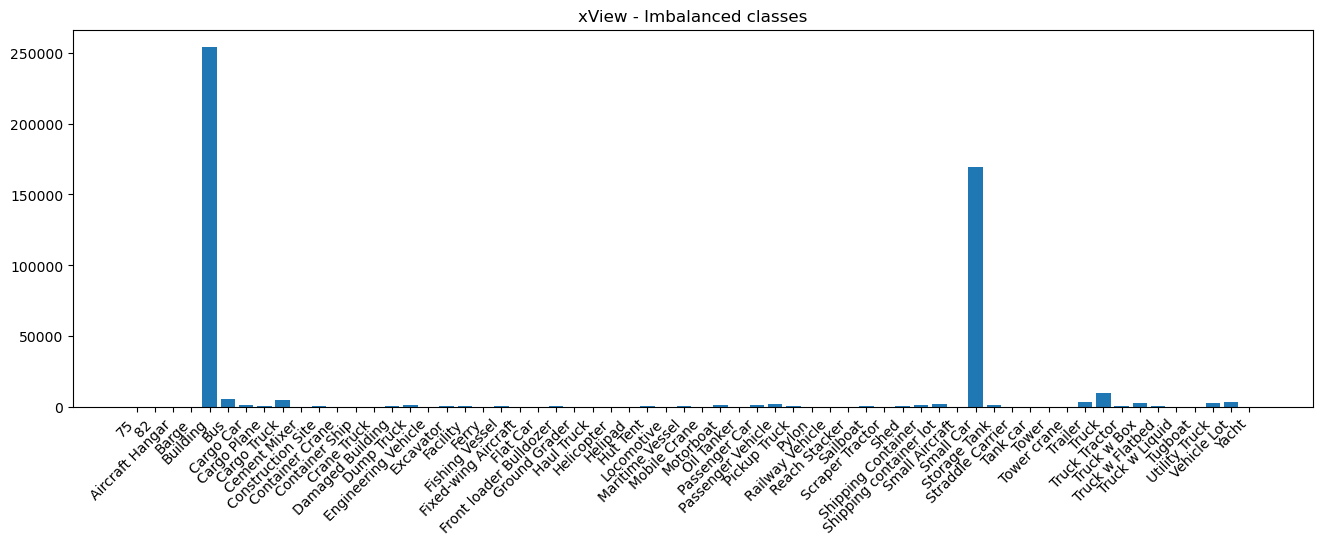

In [20]:
ys = [x['num_examples'] for x in class_info.values()]
xs = [x for x in class_info.keys()]
plt.figure(figsize=(16, 5), dpi=100)
plt.bar(xs, ys)
plt.xticks(rotation=45, ha='right')
#plt.yscale('log')
plt.title("xView - Imbalanced classes")
plt.savefig("xview_imbalanced_linear.png",
            dpi=100,
            bbox_inches='tight')
plt.show()

In [23]:
# BALANCE THE TRAINING DATA (don't need to balance the testing data?)
# take a random sample of n=500 (max) from each class
train_or_val = 'train'
N_EXAMPLES = 500
random.seed(42)

for root, dirs, filenames in os.walk("chips_train", topdown=False):
    pass

if not os.path.exists('chips_'+train_or_val+'_'+str(N_EXAMPLES)):
    os.makedirs('chips_'+train_or_val+'_'+str(N_EXAMPLES))

for d in dirs:
    
    if not os.path.exists('chips_'+train_or_val+'_'+str(N_EXAMPLES)+'/'+d):
        os.makedirs('chips_'+train_or_val+'_'+str(N_EXAMPLES)+'/'+d)
    
    for root, dirs, filenames in os.walk("chips_train/"+d, topdown=False):
        pass

    # if > 1k examples, take random sample
    if len(filenames) > N_EXAMPLES:
        filenames = random.sample(filenames, N_EXAMPLES)
    print(d, len(filenames))
    for f in filenames:
        sourcefile = "chips_train/"+d+"/"+f
        destfile = "chips_train_"+str(N_EXAMPLES)+"/"+d+"/"+f
        copyfile(sourcefile, destfile)

75 40
82 25
Aircraft Hangar 169
Barge 152
Building 500
Bus 500
Cargo Car 500
Cargo Plane 500
Cargo Truck 500
Cement Mixer 222
Construction Site 500
Container Crane 145
Container Ship 266
Crane Truck 141
Damaged Building 500
Dump Truck 500
Engineering Vehicle 165
Excavator 500
Facility 500
Ferry 166
Fishing Vessel 500
Fixed-wing Aircraft 60
Flat Car 95
Front loader Bulldozer 500
Ground Grader 73
Haul Truck 268
Helicopter 56
Helipad 95
Hut Tent 500
Locomotive 91
Maritime Vessel 500
Mobile Crane 263
Motorboat 500
Oil Tanker 65
Passenger Car 500
Passenger Vehicle 500
Pickup Truck 500
Pylon 287
Railway Vehicle 14
Reach Stacker 54
Sailboat 500
Scraper Tractor 59
Shed 500
Shipping Container 500
Shipping container lot 500
Small Aircraft 298
Small Car 500
Storage Tank 500
Straddle Carrier 54
Tank car 98
Tower 70
Tower crane 130
Trailer 500
Truck 500
Truck Tractor 500
Truck w Box 500
Truck w Flatbed 500
Truck w Liquid 115
Tugboat 172
Utility Truck 500
Vehicle Lot 500
Yacht 356


In [24]:
for root, dirs, filenames in os.walk("chips_train_"+str(N_EXAMPLES), topdown=False):
    pass

class_info = {}
for d in dirs:
    all_sizes = []
    for root, dirs, filenames in os.walk("chips_train_"+str(N_EXAMPLES)+"/"+d, topdown=False):
        pass
    print(d, len(filenames))
    for f in filenames:
        imgstr = "chips_train_"+str(N_EXAMPLES)+"/"+d+"/"+f
        img = Image.open(imgstr)
        arr = np.asarray(img)
        all_sizes.append(arr.shape[:2])
    class_info[d] = {
        'num_examples': len(filenames),
        'min': np.min(all_sizes),
        'max': np.max(all_sizes),
        'mean': np.mean(all_sizes),
        'median': np.median(all_sizes)
    }

75 40
82 25
Aircraft Hangar 169
Barge 152
Building 500
Bus 500
Cargo Car 500
Cargo Plane 500
Cargo Truck 500
Cement Mixer 222
Construction Site 500
Container Crane 145
Container Ship 266
Crane Truck 141
Damaged Building 500
Dump Truck 500
Engineering Vehicle 165
Excavator 500
Facility 500
Ferry 166
Fishing Vessel 500
Fixed-wing Aircraft 60
Flat Car 95
Front loader Bulldozer 500
Ground Grader 73
Haul Truck 268
Helicopter 56
Helipad 95
Hut Tent 500
Locomotive 91
Maritime Vessel 500
Mobile Crane 263
Motorboat 500
Oil Tanker 65
Passenger Car 500
Passenger Vehicle 500
Pickup Truck 500
Pylon 287
Railway Vehicle 14
Reach Stacker 54
Sailboat 500
Scraper Tractor 59
Shed 500
Shipping Container 500
Shipping container lot 500
Small Aircraft 298
Small Car 500
Storage Tank 500
Straddle Carrier 54
Tank car 98
Tower 70
Tower crane 130
Trailer 500
Truck 500
Truck Tractor 500
Truck w Box 500
Truck w Flatbed 500
Truck w Liquid 115
Tugboat 172
Utility Truck 500
Vehicle Lot 500
Yacht 356


In [25]:
print('min', np.min([x['min'] for x in class_info.values()]))
print('max', np.max([x['max'] for x in class_info.values()]))
print('mean', np.mean([x['mean'] for x in class_info.values()]))
print('median', np.median([x['median'] for x in class_info.values()]))

min 1
max 2421
mean 59.08602395157214
median 37.25


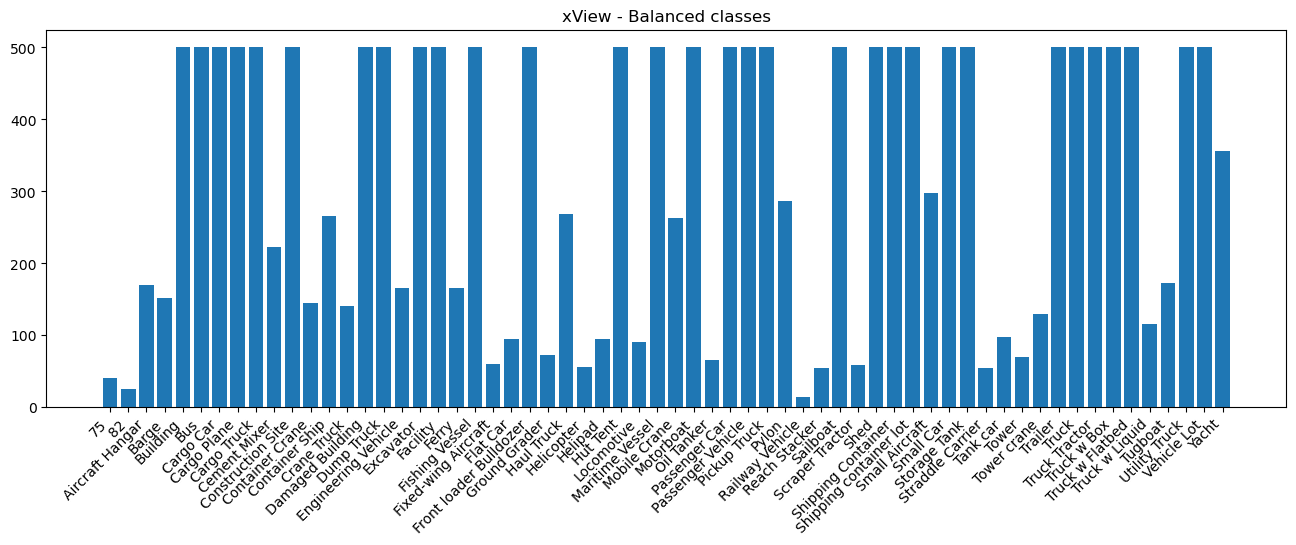

In [27]:
ys = [x['num_examples'] for x in class_info.values()]
xs = [x for x in class_info.keys()]
plt.figure(figsize=(16, 5), dpi=100)
plt.bar(xs, ys)
plt.xticks(rotation=45, ha='right')
plt.title("xView - Balanced classes")
plt.savefig("xview_balanced.png",
            dpi=100,
            bbox_inches='tight')
plt.show()